# Sergio Camposortega
# MDNA 2021
# Machine Learning

## 1. Research Question
Attrition have been increasing in different places of the world and we want to know

- what are the causes of it? 
- Could it be some characteristics demographics or if they grow his skills go to another job?

## 2. Find a relevant dataset
## Context Data (Description Data Kaggle)
You are provided with the monthly information for a segment of employees for 2016 and 2017 and tasked to predict whether a current employee will be leaving the organization in the upcoming two quarters (01 Jan 2018 - 01 July 2018) or not, given:

Demographics of the employee (city, age, gender etc.)
Tenure information (joining date, Last Date)
Historical data regarding the performance of the employee (Quarterly rating, Monthly business acquired, designation, salary)

The data contains 19,104 instances (employees) with other features such as Age, gender, city, Date of joining, Last working date, Designation etc

We download from kaggle the Predicting Employee Attrition Data https://www.kaggle.com/datasets/pavan9065/predicting-employee-attrition

## Explore the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,GradientBoostingClassifier)

from sklearn.model_selection import (train_test_split,GridSearchCV)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (FunctionTransformer, StandardScaler)

from sklearn.metrics import(classification_report, roc_auc_score)
from sklearn.inspection import plot_partial_dependence

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

import warnings

plt.style.use('ggplot')

In [2]:
df = pd.read_csv('train_data.csv')
df.head()

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating
0,2016-01-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,2381060,2
1,2016-02-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,-665480,2
2,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,0,2
3,2017-11-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1
4,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   MMM-YY                19104 non-null  object
 1   Emp_ID                19104 non-null  int64 
 2   Age                   19104 non-null  int64 
 3   Gender                19104 non-null  object
 4   City                  19104 non-null  object
 5   Education_Level       19104 non-null  object
 6   Salary                19104 non-null  int64 
 7   Dateofjoining         19104 non-null  object
 8   LastWorkingDate       1616 non-null   object
 9   Joining Designation   19104 non-null  int64 
 10  Designation           19104 non-null  int64 
 11  Total Business Value  19104 non-null  int64 
 12  Quarterly Rating      19104 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 1.9+ MB


We have 19,104 registers

As we see I have some null data at the column LastWorkingDate, but this is actually fine because it is our dependent variable, let's create it

Text(0, 0.5, 'Percentage')

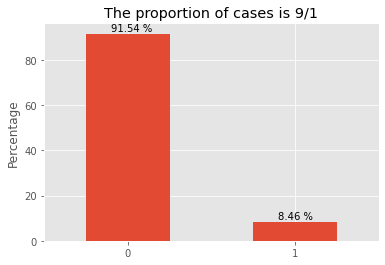

In [4]:
df['target'] = df.LastWorkingDate.notnull().astype(int)
df_plot = df['target'].value_counts(normalize=True) * 100
df_plot.plot.bar(rot=0, title='The proportion of cases is 9/1')
for idx,val in enumerate(df_plot):
    plt.text(idx-0.1,val+1, '%.2f %%' %val)
    
plt.ylabel('Percentage')


Let's begin the exploratory data analysis with some statistics and charts

In [5]:
df.Emp_ID.nunique(), df['MMM-YY'].min(),df['MMM-YY'].max()

(2381, '2016-01-01', '2017-12-01')

We have data of 2,381 employees from 2016-01-01 to 2017-12-01.

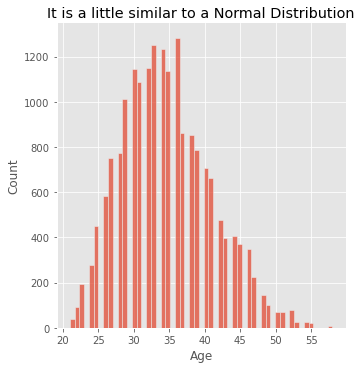

In [6]:
sns.displot(df.Age, kind='hist')
plt.title('It is a little similar to a Normal Distribution');

In [7]:
print('The mean of the age is: %.2f and the median is: %i' %(df.Age.mean(),df.Age.median()))

The mean of the age is: 34.65 and the median is: 34


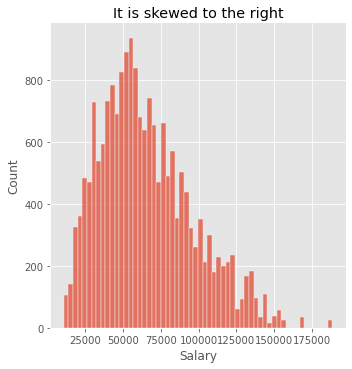

In [8]:
sns.displot(df.Salary, kind='hist')
plt.title('It is skewed to the right');

In [9]:
print('The mean of the salary is: %i and the median is: %i' %(df.Salary.mean(),df.Salary.median()))
print('The difference is off  5000 USD :o')

The mean of the salary is: 65652 and the median is: 60087
The difference is off  5000 USD :o


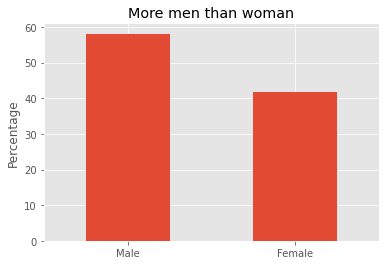

In [10]:
(df.Gender.value_counts(normalize=True)*100).plot.bar(rot=0, title='More men than woman')
plt.ylabel('Percentage');

As we see at the chart at this datasets we have 16% of difference between them

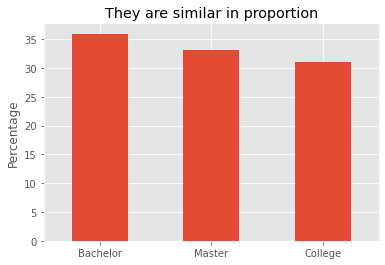

In [11]:
(df.Education_Level.value_counts(normalize=True)*100).plot.bar(rot=0, title='They are similar in proportion')
plt.ylabel('Percentage');

They have similar proportion at the education level.

<AxesSubplot:xlabel='City', ylabel='count'>

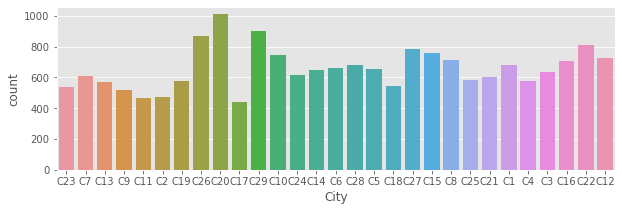

In [12]:
df.City.nunique()
plt.figure(figsize=(10,3))
sns.countplot(data=df,x='City')

We have 29 different cities and sufficient variance on each category

We don't have context about the columns Joining Designation and Designation, so we will drop it.

In [13]:
df.drop(['Joining Designation','Designation'],axis=1, inplace=True)

<AxesSubplot:xlabel='Quarterly Rating', ylabel='count'>

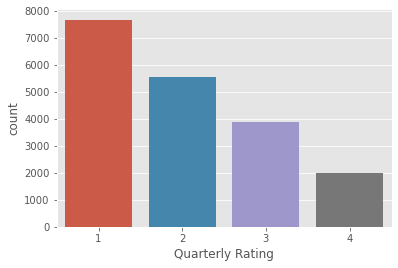

In [14]:
sns.countplot(data=df,x='Quarterly Rating') #it is the Quarterly rating

In [15]:
df.groupby('target')['Quarterly Rating'].value_counts().unstack()

Quarterly Rating,1,2,3,4
target,,,,
0,6247,5407,3867,1967
1,1432,146,28,10


Now we know how our data is, our next job is to describe the relationship with the target variable

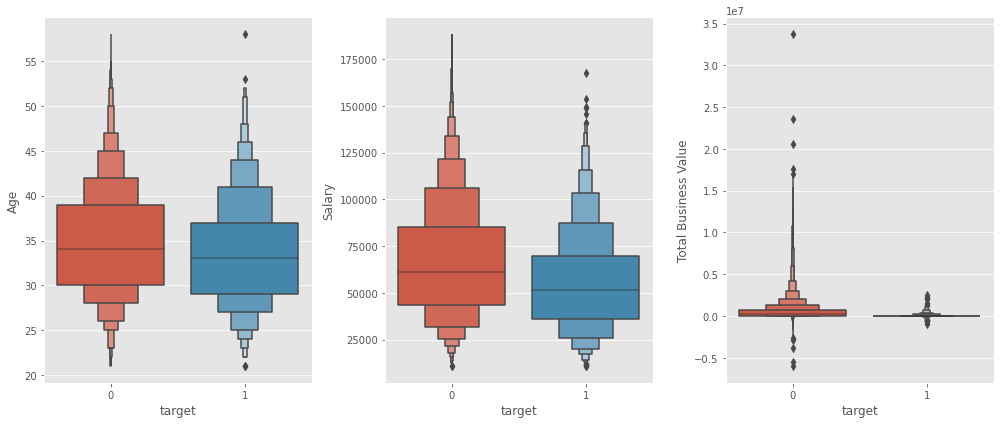

In [25]:
cat_cols = ['Gender','City','Education_Level']
num_cols = ['Age','Salary', 'Total Business Value']
plt.figure(figsize=(14,6))
for idx,col in enumerate(num_cols):
    df_temp = df[['target']+[col]]
    plt.subplot(1,3,idx+1)
    sns.boxenplot(data=df_temp,x='target',y=col)
    plt.tight_layout()

We see that young employees have a little more chance to quit his job and also a low salary could be the reason.
For total Business value we see a lot of outliers.

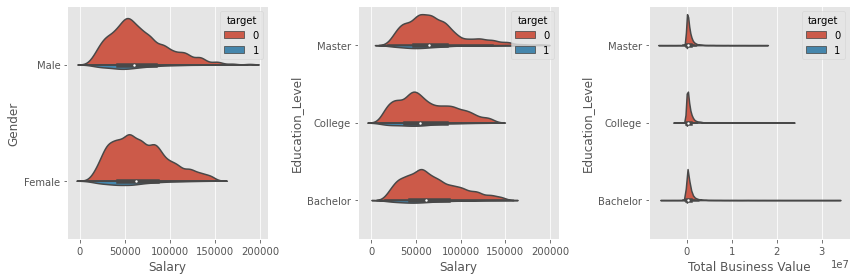

In [26]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
sns.violinplot(data=df, y='Gender', x='Salary', hue='target', split=True, scale='count')
plt.subplot(1,3,2)
sns.violinplot(data=df, y='Education_Level', x='Salary', hue='target', split=True, scale='count')
plt.subplot(1,3,3)
sns.violinplot(data=df, y='Education_Level', x='Total Business Value', hue='target', split=True, scale='count')
plt.tight_layout()

We compare with our target value and the proportion of positive cases is to low, we cannot see a great difference. But in the majority of the registers we see that a Master Degree could help you to get a better salary.

Let's create some feature that we think would be helpfully to our machine learning model

- The employee has moved out?
- The employee has change his Education level?
- How many months have the same salary the employee?
- categorical time date of joining date.
- Dummy variables of categorical data leaving one category out

In [27]:
df_join = df.groupby('Emp_ID').City.shift().fillna(method='backfill') # we groupby Emply_ID and we create a column with the city of the next register
# then we join to our original dataset and compare if the city is the same in each register, 
# if it's the same the value is 0 (no change) and if not it is 1 (move out)
df_join.name = 'city_2' # we need to change the name of the series to join them quickly
df = df.join(df_join)
df.head()

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Total Business Value,Quarterly Rating,target,city_2
0,2016-01-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,2381060,2,0,C23
1,2016-02-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,-665480,2,0,C23
2,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,0,2,1,C23
3,2017-11-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,0,1,0,C7
4,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,0,1,0,C7


In [28]:
df['moved_out'] = np.where(df.City == df.city_2, 0,1)
df.drop('city_2', axis=1, inplace=True)
df['moved_out'].value_counts(normalize=True), df.groupby('target').moved_out.mean()

(0    0.990735
 1    0.009265
 Name: moved_out, dtype: float64,
 target
 0    0.004403
 1    0.061881
 Name: moved_out, dtype: float64)

In the first Series we see a low proportion of cases, but if we see on the target variable it is a little significant

In [29]:
df_join = df.groupby('Emp_ID').Education_Level.shift().fillna(method='backfill') # we groupby Emply_ID and we create a column with the edu
# of the next register then we join to our original dataset and compare if the city is the same in each register, 
# if it's the same the value is 0 (no change) and if not it is 1 (change education level)
df_join.name = 'education_level_2' # we need to change the name of the series to join them quickly
df = df.join(df_join)
df.head()

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Total Business Value,Quarterly Rating,target,moved_out,education_level_2
0,2016-01-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,2381060,2,0,0,Master
1,2016-02-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,-665480,2,0,0,Master
2,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,0,2,1,0,Master
3,2017-11-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,0,1,0,0,Master
4,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,0,1,0,0,Master


In [30]:
df['change_education'] = np.where(df.Education_Level == df.education_level_2, 0,1)
df.drop('education_level_2', axis=1, inplace=True)
df['change_education'].value_counts(normalize=True), df.groupby('target').change_education.mean()

(0    0.993562
 1    0.006438
 Name: change_education, dtype: float64,
 target
 0    0.002973
 1    0.043936
 Name: change_education, dtype: float64)

Similar description like in the cities

In [31]:
df_join = df.groupby('Emp_ID').Salary.shift()
df_join.name = 'salary_2'
df = df.join(df_join)
df['emp_id_2'] = df['Emp_ID'].shift()

In [32]:
df[['Emp_ID','Salary']] = df[['Emp_ID','Salary']].astype(float)

In [33]:
# Creating the variable
df['temp'] = np.where(df.Salary == df.salary_2, 1, 0)
df['month_same_salary'] = df.groupby(['Emp_ID','Salary']).temp.cumsum()
df.drop(['salary_2','temp'], axis=1, inplace=True)

In [34]:
# We detect an error because the downgrade the salary
df.at[4012,'month_same_salary'] = 0
df[df.Emp_ID ==  582]

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Total Business Value,Quarterly Rating,target,moved_out,change_education,emp_id_2,month_same_salary
3999,2016-11-01,582.0,32,Female,C10,Master,47682.0,2016-11-25,NaN,0,1,0,0,0,581.0,0
4000,2016-12-01,582.0,32,Female,C10,Master,47682.0,2016-11-25,NaN,0,1,0,0,0,582.0,1
4001,2017-01-01,582.0,32,Female,C10,Master,47682.0,2016-11-25,NaN,0,2,0,0,0,582.0,2
4002,2017-02-01,582.0,32,Female,C10,Master,47682.0,2016-11-25,NaN,2750560,2,0,0,0,582.0,3
4003,2017-03-01,582.0,33,Female,C10,Master,47682.0,2016-11-25,NaN,500000,2,0,0,0,582.0,4
4004,2017-04-01,582.0,33,Female,C10,Master,47682.0,2016-11-25,NaN,10703580,4,0,0,0,582.0,5
4005,2017-05-01,582.0,33,Female,C10,Master,47682.0,2016-11-25,NaN,2000000,4,0,0,0,582.0,6
4006,2017-06-01,582.0,33,Female,C10,Master,47682.0,2016-11-25,NaN,1000000,4,0,0,0,582.0,7
4007,2017-07-01,582.0,33,Female,C10,Master,47682.0,2016-11-25,NaN,2658210,4,0,0,0,582.0,8
4008,2017-08-01,582.0,33,Female,C10,Master,47682.0,2016-11-25,NaN,2212780,4,0,0,0,582.0,9


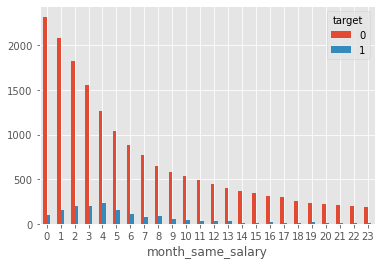

In [37]:
pd.crosstab(df.target, df.month_same_salary).T.plot.bar(rot=0);

We see that have a unusual effect the variable, because it is increasing linearly but passing 5 months the factor of the same salary it's decays

In [38]:
df['Dateofjoining'] = pd.to_datetime(df['Dateofjoining'])
df['month_joining'] = df['Dateofjoining'].dt.month
df['year_joining'] = df['Dateofjoining'].dt.year

In [39]:
cat_cols = cat_cols + ['month_joining','year_joining']
df = pd.get_dummies(df,columns=cat_cols,drop_first=True)

## Start building models:
- Build a supervised learning model. This can either be some type of classifier model, or a collection of classification rules.



To train the model we have to split the data, creating in the process 2 datasets, train and test in a proportion (80,20) applying a k-cross validation to optimize the hyper parameters.

In [40]:
num_cols = [col for col in df.select_dtypes(include='number').columns if col not in ['Emp_ID','target','emp_id_2']]
std_cols = ['Age', 'Salary','Total Business Value']
cat_cols = [col for col in num_cols if col not in std_cols]

In [41]:
Xtrain,Xtest, ytrain, ytest = train_test_split(df[num_cols], df.target, test_size=0.2, random_state = 8)

Remember that the proportion of the target is unbalanced so we have to transform the data to get a better performance of the models, we will apply an under sampling

In [42]:
count_class_0, count_class_1 = ytrain.value_counts()

In [43]:
# Clase mayoritaría
x_data_majority = Xtrain.loc[ytrain == 0]
y_data_majority = ytrain.loc[ytrain == 0]

# Clase minoritaría
x_data_minority = Xtrain.loc[ytrain == 1]
y_data_minority = ytrain.loc[ytrain == 1]

In [44]:
y_df_major_downsampled = y_data_majority.sample(n = count_class_1, random_state=8)
x_df_major_downsampled = x_data_majority.loc[y_df_major_downsampled.index]

In [45]:
y_data_downsampled = pd.concat([y_df_major_downsampled, y_data_minority])
x_data_downsampled = pd.concat([x_df_major_downsampled, x_data_minority])

In [46]:
print ('Final length of our dataset:\n', y_data_downsampled.value_counts())

Final length of our dataset:
 1    1285
0    1285
Name: target, dtype: int64


We create a function to train, optimize hyperparameters and evaluate the models

In [47]:
def grid_fit_cv(model, param_grid,stand_cols, stand=False, cv=10):
    
    def stand_feat(df_temp):
        ss = StandardScaler()
        idx = df_temp.index
        df_temp_ss = pd.DataFrame(ss.fit_transform(df_temp[stand_cols]), columns=stand_cols, index=idx)
        df_temp_all = pd.concat([df_temp_ss, df_temp[cat_cols]],1)
        
        return df_temp_all
    
    print('Preparing the data')
    if stand:
        transformer = FunctionTransformer(stand_feat)
        pipe = Pipeline(steps=[('stand', transformer), ('model',model)])
    else:
        print('Ok, not necesary')
        pipe = Pipeline(steps=[('model',model)])
    
    print('Time to create the GridSearch')   
    clf = GridSearchCV(pipe, param_grid, n_jobs=-1, verbose=1, cv=cv)
   
    clf.fit(x_data_downsampled, y=y_data_downsampled)
    print(clf.best_score_, clf.best_params_)
    
    y_pred = clf.predict(Xtest)
    print(classification_report(ytest, y_pred))
    
    return clf

The function standardize only the numeric variables and not the categorical variables, that is why we create the Function Transformer, also to not have data leakage we create a Pipeline to standardize at every train set during the k-cross validation. We standardize only in the Logistic Regression.

During this Pipeline we optimize the hyper parameters using cross validation and the models that we use are:

- Logistic Regression
- Decision Tree
- Random Forest
- Gradient Boosting Machine

all for classification problems.

In [48]:
%%time

# Bad Practice but its look ugly... BTW I check and it is in the only chunk that I get Warnings
warnings.filterwarnings("ignore")

param_grid = {'model__C':np.logspace(-5,5,20), 'model__penalty':['l1','l2']}
lr_model = grid_fit_cv(LogisticRegression(), param_grid,std_cols, stand=True)

Preparing the data
Time to create the GridSearch
Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s


0.7785992217898833 {'model__C': 0.04832930238571752, 'model__penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.99      0.61      0.76      3490
           1       0.18      0.92      0.31       331

    accuracy                           0.64      3821
   macro avg       0.59      0.77      0.53      3821
weighted avg       0.92      0.64      0.72      3821

Wall time: 6.45 s


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    6.3s finished


In [49]:
%%time

param_grid = {'model__max_depth':np.arange(1,12),'model__criterion':['entropy','gini']}
dt_model = grid_fit_cv(DecisionTreeClassifier(), param_grid, std_cols,stand=False)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Preparing the data
Ok, not necesary
Time to create the GridSearch
Fitting 10 folds for each of 22 candidates, totalling 220 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s


0.8319066147859921 {'model__criterion': 'gini', 'model__max_depth': 4}
              precision    recall  f1-score   support

           0       0.98      0.77      0.87      3490
           1       0.26      0.86      0.40       331

    accuracy                           0.78      3821
   macro avg       0.62      0.82      0.63      3821
weighted avg       0.92      0.78      0.83      3821

Wall time: 987 ms


[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:    0.9s finished


In [50]:
%%time

param_grid = {'model__n_estimators': np.linspace(300,600,10).astype(int), }
rf_model = grid_fit_cv(RandomForestClassifier(criterion='gini', max_depth=9), param_grid, std_cols, cv=5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Preparing the data
Ok, not necesary
Time to create the GridSearch
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   14.2s finished


0.8350194552529183 {'model__n_estimators': 433}
              precision    recall  f1-score   support

           0       0.98      0.80      0.88      3490
           1       0.29      0.85      0.43       331

    accuracy                           0.81      3821
   macro avg       0.63      0.82      0.66      3821
weighted avg       0.92      0.81      0.84      3821

Wall time: 15.4 s


In [51]:
%%time

param_grid = {'model__n_estimators': np.linspace(1,100,5).astype(int),
              'model__learning_rate':np.linspace(1e-5,1,3),
             'model__max_depth':np.arange(1,4)}
gbm_model = grid_fit_cv(GradientBoostingClassifier(), param_grid, std_cols,cv=5)

Preparing the data
Ok, not necesary
Time to create the GridSearch
Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 210 out of 225 | elapsed:    6.7s remaining:    0.4s


0.8392996108949417 {'model__learning_rate': 0.500005, 'model__max_depth': 2, 'model__n_estimators': 25}
              precision    recall  f1-score   support

           0       0.98      0.79      0.88      3490
           1       0.28      0.86      0.42       331

    accuracy                           0.79      3821
   macro avg       0.63      0.82      0.65      3821
weighted avg       0.92      0.79      0.84      3821

Wall time: 7.81 s


[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:    7.6s finished


At this point we have train 4 algorithms with the next results:

- Logistic Regression with l2 penalty and a C of 0.048 giving an accuracy of 0.64 and a recall 0.92
- Decision Tree Classifier with a split criterion of gini and a max depth of 4 with an accuracy of 0.78 and a recall of 0.86
- Random Forest Classifier with a split criterion of gini, max depth equal 9 and 566 tree estimators giving us an accuracy of 0.80 and a recall of 0.85
- Gradient Boosting Classifier with a learning rate of 0.5, max depth of 2 and 25 tree estimators giving an accuracy of 0.79 and a recall of 0.86

We choice the Random Forest Classifier as the best model having a good performance on accuracy and recall

## Interpret the model

We have an ensemble model so we will use the feature importance and the marginal effects to describe what see the model.


<AxesSubplot:>

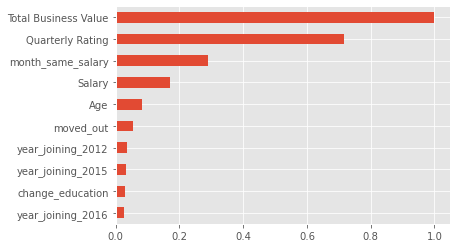

In [52]:
best_model = rf_model.best_estimator_.named_steps['model']
dict_importance = dict(zip(x_data_downsampled.columns, best_model.feature_importances_))
df_imp = (pd.Series(dict_importance).sort_values())/pd.Series(dict_importance).max()
df_imp.tail(10).plot.barh()

The Random Forest have the top 5 variables:
- Total Business Value
- Quarterly Rating
- month_same_salary
- Salary
- Age

Our intuition says that if you don't have a great impact in the company the employee quit, also if your labor performance is low probably you will go to another job, maybe the employee think that he could have a better rating. By other way, if an employee don't have a promotion probably he will quit. And the factors of Age and Salary can be by the job competition to have the better talent and young persons can easily change the job because they don't have family and not need a stable job

In [53]:
f_imp_sort = df_imp.tail(10).sort_values(ascending=False)
names = list(f_imp_sort.head(10).index)
feat = []
lista_casv = num_cols

for i in names:
    if i in lista_casv:
        feat.append(lista_casv.index(i))

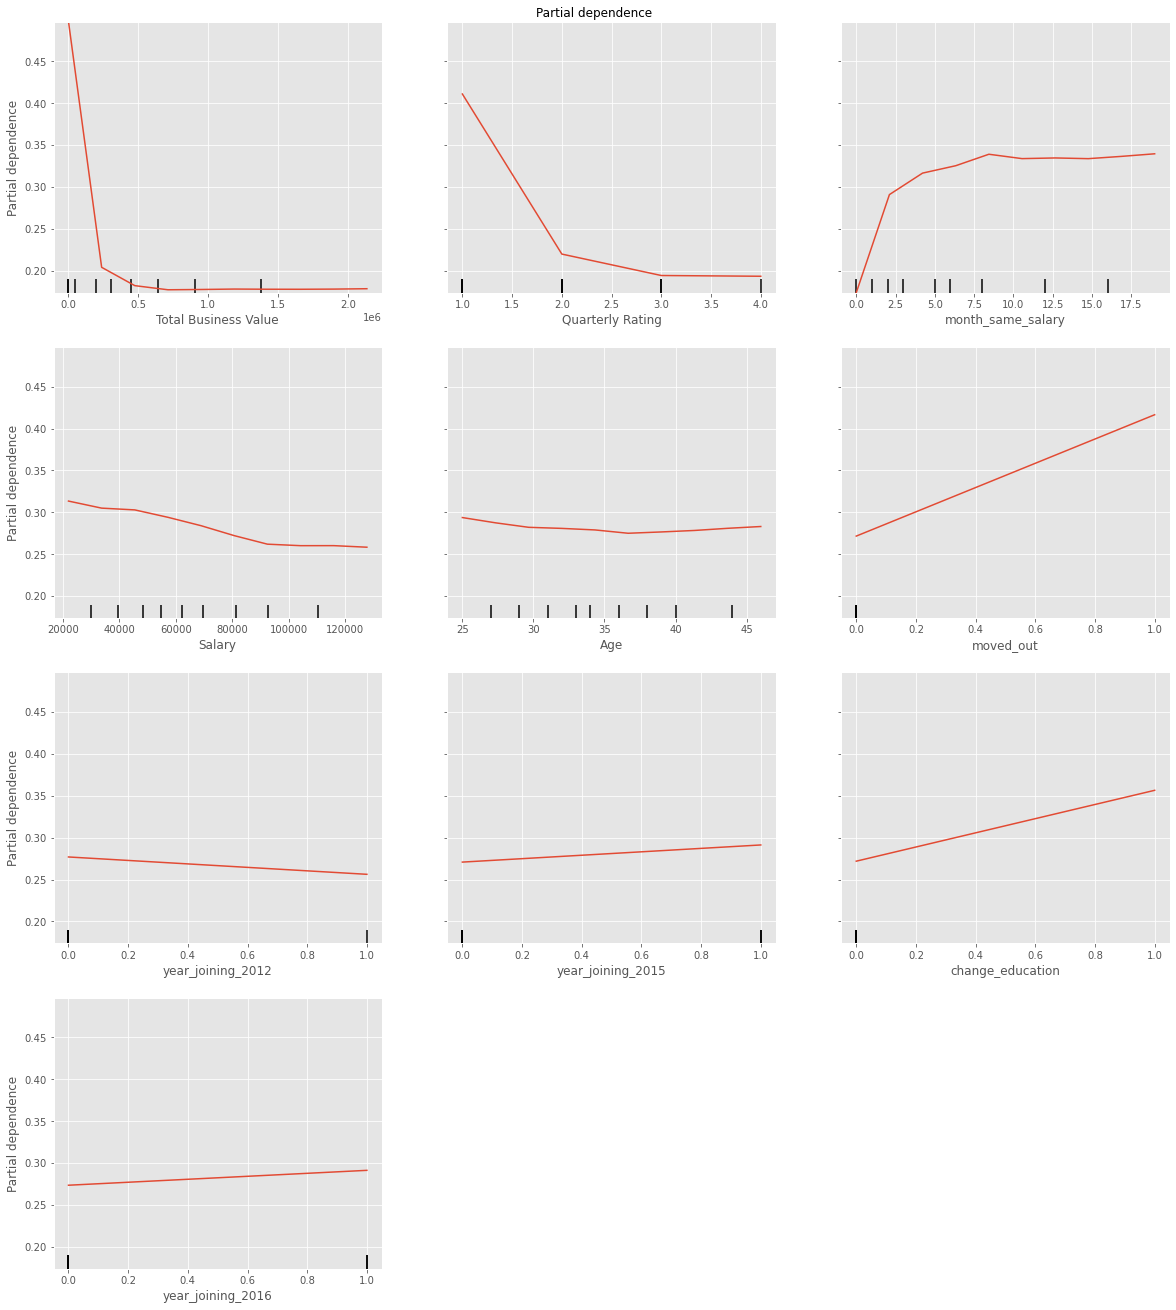

In [54]:
fig = plt.figure()
plot_partial_dependence(best_model,x_df_major_downsampled[num_cols], feat, feature_names=num_cols, fig=fig,
                        grid_resolution=10)
fig.suptitle('Partial dependence')
plt.subplots_adjust(top=0.97)  # tight_layout causes overlap with suptitle
fig.set_size_inches(20, 20.5);

The margin effects describe us how the probability of attrition is higher o lower depending in the change of the x values. For example
For the Total Business Value it is counterintuitive because from more value lower is the probability, for this variable we see that have many outliers, and possibly it is disturbing the model.

For the rating it have a good behavior because employees with high rating possibly have better benefits or salary and don't quit his job. Also an Hypothesis is that some employees feel unfair his rating and that is the reason they leave his job.

Our variable of month_same_salary indicates that if some employee pass his trial period successfully and don't have a better salary they quit, however if the employee passing the 5 month the probability of quit goes down 

The salary describes the natural, if you have a good paid probably you don't quit.

## Unsupervised learning

Let's look to the people that quit to his job and make a cluster and describe the groups

In [55]:
df_att = df[df.target == 1]
df_att.head(2)

,MMM-YY,Emp_ID,Age,Salary,Dateofjoining,LastWorkingDate,Total Business Value,Quarterly Rating,target,moved_out,...,month_joining_10,month_joining_11,month_joining_12,year_joining_2011,year_joining_2012,year_joining_2013,year_joining_2014,year_joining_2015,year_joining_2016,year_joining_2017
2,2016-03-01,1.0,28,57387.0,2015-12-24,2016-03-11,0,2,1,0,...,0,0,1,0,0,0,0,1,0,0
9,2017-04-01,4.0,43,65603.0,2016-12-07,2017-04-27,0,1,1,0,...,0,0,1,0,0,0,0,0,1,0


For clustering we need to preprocess the data normalizing the data. So we have to apply a min-max scaler.

In [56]:
std = MinMaxScaler()
df_std = std.fit_transform(df_att[num_cols])
df_att2 = pd.DataFrame(df_std,columns=num_cols)
df_att2.head()

,Age,Salary,Total Business Value,Quarterly Rating,moved_out,change_education,month_same_salary,Gender_Male,City_C10,City_C11,...,month_joining_10,month_joining_11,month_joining_12,year_joining_2011,year_joining_2012,year_joining_2013,year_joining_2014,year_joining_2015,year_joining_2016,year_joining_2017
0,0.189189,0.297049,0.279729,0.333333,0.0,0.0,0.086957,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.594595,0.349377,0.279729,0.000000,0.0,0.0,0.173913,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.216216,0.226869,0.279729,0.000000,0.0,0.0,0.086957,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.351351,0.381559,0.279729,0.000000,0.0,0.0,0.086957,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.378378,0.110623,0.279729,0.000000,0.0,0.0,0.217391,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


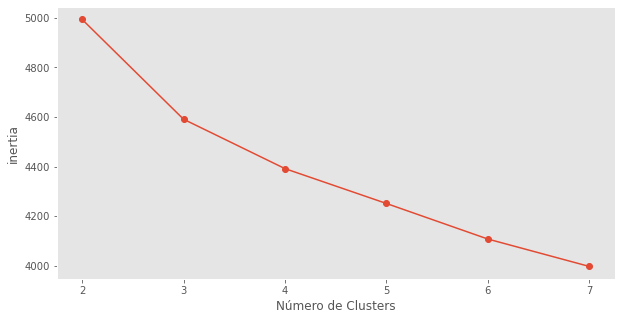

In [57]:
inertias = []
models = {}
ks = range(2, 8)
for k in ks:
    
    kmeans = KMeans(n_clusters=k, random_state=5)
    kmeans.fit(df_att2.values)
    inertia = kmeans.inertia_
    inertias.append(inertia)
    models[k] = kmeans
    
plt.figure(figsize=(10,5))
plt.plot(ks, inertias, '-o')
plt.xlabel(u'Número de Clusters')
plt.ylabel(u'inertia')
plt.grid()
plt.xticks(ks);

The effect to see where the best k is not very clearly but we will took k=3 to get the clusters, this could be because he have little data (1,616 registers)

In [58]:
kmeans3 = models[3]
df_att2['cluster'] = kmeans3.predict(df_att2)
df_att2.head()

,Age,Salary,Total Business Value,Quarterly Rating,moved_out,change_education,month_same_salary,Gender_Male,City_C10,City_C11,...,month_joining_11,month_joining_12,year_joining_2011,year_joining_2012,year_joining_2013,year_joining_2014,year_joining_2015,year_joining_2016,year_joining_2017,cluster
0,0.189189,0.297049,0.279729,0.333333,0.0,0.0,0.086957,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,0.594595,0.349377,0.279729,0.000000,0.0,0.0,0.173913,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
2,0.216216,0.226869,0.279729,0.000000,0.0,0.0,0.086957,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
3,0.351351,0.381559,0.279729,0.000000,0.0,0.0,0.086957,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2
4,0.378378,0.110623,0.279729,0.000000,0.0,0.0,0.217391,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1


Now with a predict column of the cluster let's describe the data.

In [77]:
df_original = pd.read_csv('train_data.csv')
df_cluster = df_att.merge(df_original, how='left', left_index=True, right_index=True, suffixes=('_x', ''))
df_cluster

,MMM-YY_x,Emp_ID_x,Age_x,Salary_x,Dateofjoining_x,LastWorkingDate_x,Total Business Value_x,Quarterly Rating_x,target,moved_out,...,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating
2,2016-03-01,1.0,28,57387.0,2015-12-24,2016-03-11,0,2,1,0,...,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,0,2
9,2017-04-01,4.0,43,65603.0,2016-12-07,2017-04-27,0,1,1,0,...,Male,C13,Master,65603,2016-12-07,2017-04-27,2,2,0,1
12,2016-03-01,5.0,29,46368.0,2016-01-09,2016-03-07,0,1,1,0,...,Male,C9,College,46368,2016-01-09,2016-03-07,1,1,0,1
20,2017-11-01,8.0,34,70656.0,2017-09-19,2017-11-15,0,1,1,0,...,Male,C2,College,70656,2017-09-19,2017-11-15,3,3,0,1
27,2016-12-01,12.0,35,28116.0,2016-06-29,2016-12-21,0,1,1,0,...,Male,C23,Master,28116,2016-06-29,2016-12-21,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19039,2017-02-01,2779.0,28,95133.0,2017-01-26,2017-02-14,0,1,1,0,...,Male,C26,College,95133,2017-01-26,2017-02-14,3,3,0,1
19054,2016-08-01,2782.0,26,29582.0,2016-05-16,2016-08-16,0,1,1,0,...,Male,C19,Bachelor,29582,2016-05-16,2016-08-16,1,1,0,1
19081,2017-10-01,2785.0,34,12105.0,2017-08-28,2017-10-28,0,1,1,0,...,Female,C9,College,12105,2017-08-28,2017-10-28,1,1,0,1
19090,2016-09-01,2786.0,45,35370.0,2015-07-31,2016-09-22,0,1,1,0,...,Male,C19,College,35370,2015-07-31,2016-09-22,2,2,0,1


In [78]:
df_att2.cluster

0       0
1       1
2       1
3       2
4       1
       ..
1611    2
1612    1
1613    2
1614    0
1615    0
Name: cluster, Length: 1616, dtype: int32

In [79]:
df_att2.index = df_att.index
df_cluster['cluster'] = df_att2.cluster
drop_cols = [col for col in df_cluster.columns if '_x' in col or 'City_'in col or 'Gender_'in col or 'month_' in col or 'year_' in col or 'Education_Level_' in col] + [
    'emp_id_2','MMM-YY','Emp_ID', 'target', 'Dateofjoining','LastWorkingDate','Joining Designation','Designation']
df_cluster.drop(drop_cols, axis=1, inplace=True)

<AxesSubplot:>

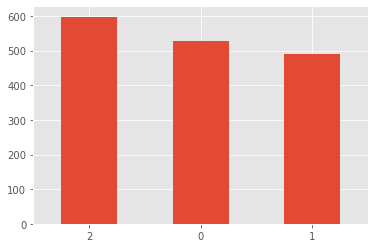

In [80]:
df_cluster.cluster.value_counts().plot.bar(rot=0)

The number of elements by cluster is homogeneous, with not big difference between them.

In [81]:
n_col = ['Age', 'Salary','Total Business Value']

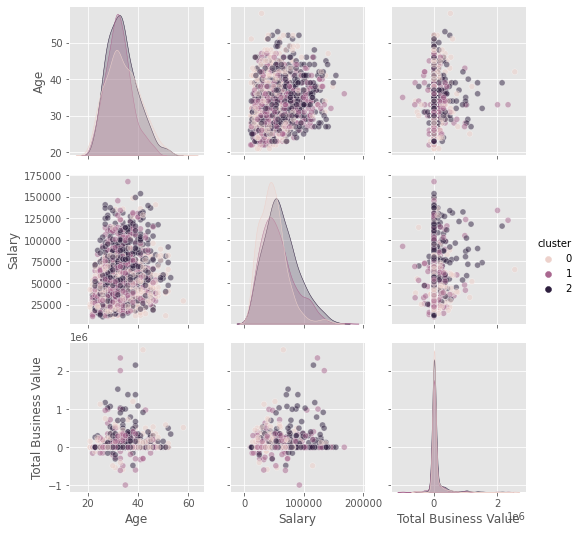

In [82]:
sns.pairplot(data = df_cluster[n_col+['cluster']], hue='cluster',plot_kws=dict(alpha=0.5))

We don't see some relation with the cluster on this chart

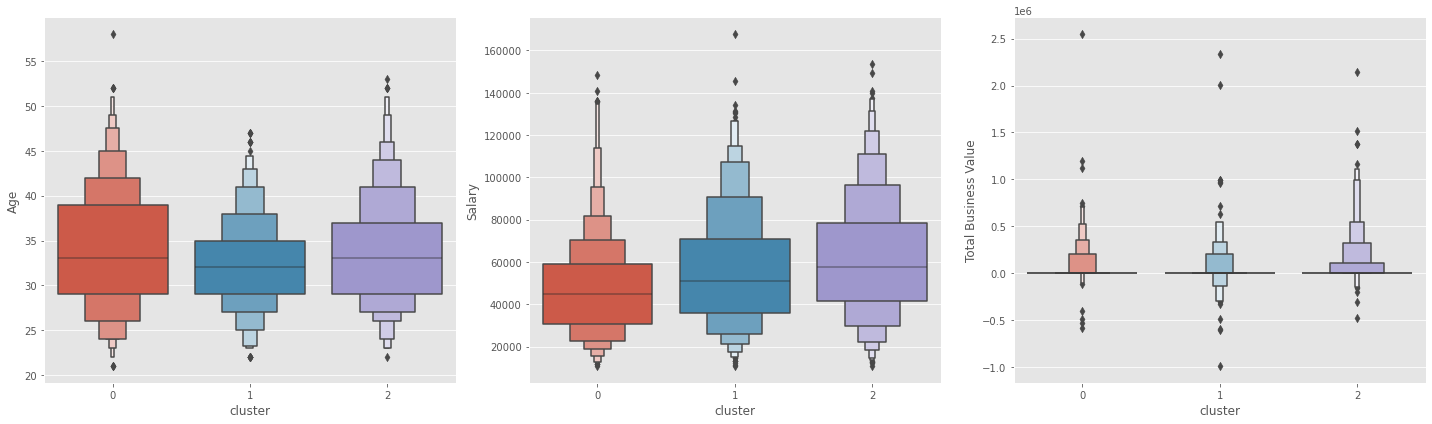

In [83]:
plt.figure(figsize=(20,6))
for idx,c in enumerate(n_col):
    plt.subplot(1,3,idx+1)
    sns.boxenplot(data=df_cluster, x='cluster', y=c)
    plt.tight_layout()

On this chart we see that the cluster 1 have younger employees, the cluster 0 have lower salaries and cluster 2 have more variance at Business Value.

In [84]:
c_cols = ['moved_out', 'change_education','Gender', 'City',
       'Education_Level','Quarterly Rating']

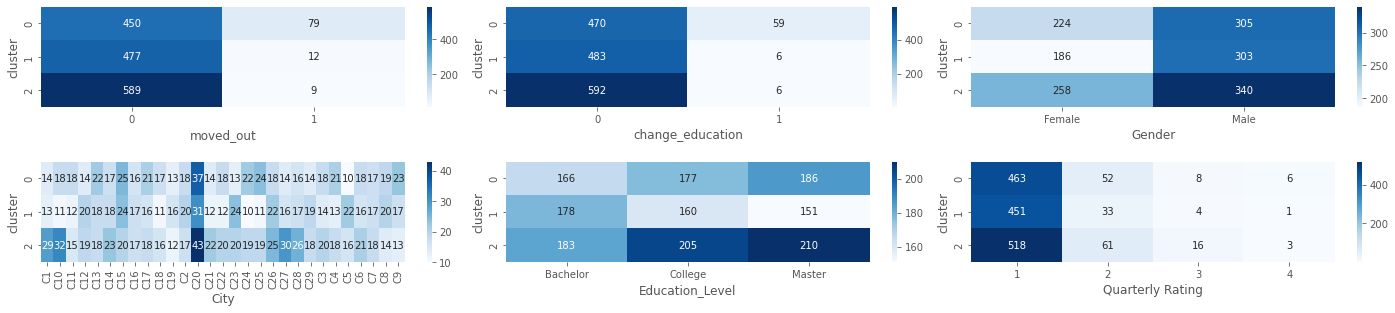

In [85]:
plt.figure(figsize=(20,6))
for idx,c in enumerate(c_cols):
    df_cross = pd.crosstab(df_cluster.cluster, df_cluster[c])
    plt.subplot(3,3,idx+1)
    sns.heatmap(df_cross, cmap='Blues', annot=True, fmt='0.0f')
    plt.tight_layout()

On this chart we count employees grouped by cluster.
- Cluster 0: 
    - have more persons that have moved
    - have more persons than other clusters that change his education level
    - it has more elements of the city 24,25 and 9, and fewer elements from city 5.
- Cluster 1:
    - have fewer women than other clusters
    - the rating is low
    - most of them have a Bachelor Degree
    - most of them are from city 23, 15 and 8 and have few employees on the city 24, 25 and 10
- Cluster 2:
   - Most of them are male
   - They have more master degree than other cluster
   - They have more collage studies than other cluster
   - most of them are from city 1,10 and 20.

# Conclusion

Answering our question if to know what are the causes of the attrition at this company? 
Could it be some characteristics demographics or if they his skills go to another job?

After doing the Exploratory Data Analysis we saw  the characteristics of the employees most of them are men with an age of 34, we have a few registers that quit his job and that complicate the analysis and the model. The salary and the Age is a factor for attrition. Some of the variables that we create help the algorithm to have a better performance and also the under sampling method to have a balanced dataset.

We could use the Gradient Boosting Machine or the Random Forest after training them, both have a good performance on the metrics of accuracy and recall.

At the interpretation we detect that a variable to check is the Total Business Value that has a counterintuitive behavior, but the Quarterly Rating and the month_same_salary variable helps to understand in some cases the attrition.

With the unsupervised model of clustering we grouped the employees and we can generate custom retention plans to keep the good employees.

----

# Appendix

Code that help me to create some stuffs in the project and other things that I don't use

In [86]:
#
# # The unsual function to count how many months have the employee with the same salary :*(
# count= 0
# val = []
# for x in range(len(df)):
#     df_row = df.iloc[x]
#     id_1 = df_row.loc['Emp_ID']
#     id_2 = df_row.loc['emp_id_2']
#     salary_1 = df_row.loc['Salary']
#     salary_2 = df_row.loc['salary_2']
    
#     if np.isnan(id_2):
#         count = 0
#         val.append(0)
#         # print(x,'entre nan')
#         continue
#     elif id_1 == id_2:
#         # print(x,'entre')
#         if salary_1 == salary_2:
#             # print(x,'entre salario')
#             count += 1
#             val.append(count)
#         elif salary_1 != salary_2:
#             count = 0
#             val.append(count)
#     elif id_1 != id_2:
#         count=0
#         val.append(count)
        
# df['month_same_salary'] = val